### Importing all libraries

In [1]:
import pandas as pd
from scipy.stats import mannwhitneyu, chisquare, fisher_exact
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import numpy as np
import requests
import io
from scipy.stats import ttest_ind
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

### For this analysis, I will be fetching the main analysis file which I host on my GitHub.

In [2]:
# Fetching the main analysis CSV file from GitHub
url = "https://raw.githubusercontent.com/AustinHendersonEconomist/CodeExamples/main/TDIE_data_main.csv"
response = requests.get(url)
df = pd.read_csv(io.StringIO(response.text))

### First, I visualize the data by comparing the distribution of reported rolls across treatment and control groups.

<Figure size 1200x800 with 0 Axes>

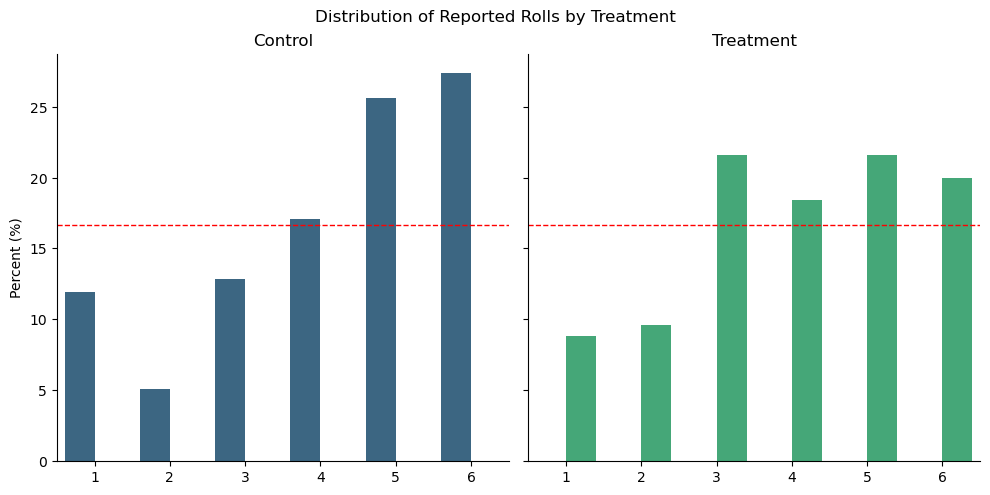

In [3]:
df['count'] = 1
grouped_df = df.groupby(['treatment', 'dieroll']).count().reset_index()
total_counts = grouped_df.groupby('treatment')['count'].transform('sum')
grouped_df['percent'] = (grouped_df['count'] / total_counts) * 100

# Plotting
plt.figure(figsize=(12, 8))
g = sns.catplot(x='dieroll', y='percent', hue='treatment', kind='bar', data=grouped_df, palette='viridis', col='treatment')
g.set_axis_labels("Die Roll", "Percent (%)")

# Add a dashed line at y=16.67
for ax in g.axes.flat:
    ax.axhline(y=16.67, color='r', linestyle='--', linewidth=1)

axes = g.axes.flat
axes[0].set_title('Control')
axes[1].set_title('Treatment')


g.set_xlabels('')
plt.suptitle('Distribution of Reported Rolls by Treatment', y=1.02)
plt.show()

### Then, I run a χ2-test against uniform distribution to check for evidence of self serving lying in treatment (testosterone) and control (placebo) groups. This would be indicated by a right-skewed distribution, i.e. more high numbers reported than we would expect via chance.

In [4]:
# 1. Chi square-test
obs1 = [14, 6, 15, 20, 30, 33]
obs2 = [11, 12, 27, 23, 27, 25]
chisq1, p1 = chisquare(obs1)
chisq2, p2 = chisquare(obs2)

print(f"Chi-squared test for treatment: chisq={round(chisq2, 2)}, p={round(p2, 2)}")
print(f"Chi-squared test for control: chisq={round(chisq1, 2)}, p={round(p1, 2)}")

Chi-squared test for treatment: chisq=13.1, p=0.02
Chi-squared test for control: chisq=26.71, p=0.0


### I find that I can reject the null-hypothesis of uniform distribution for both groups, thus, both groups are lying to increase their earnings. 

### Next, I use a Mann-Whitney U-test to Test for diferences in the distributions of reported die rolls between treatment and control. 

In [5]:
# 2. Mann-Whitney U-test
grouped_dieroll = [df['dieroll'][df['treatment'] == treatment] for treatment in df['treatment'].unique()]
U_stat, p_value = mannwhitneyu(*grouped_dieroll)
print(f"Mann-Whitney U-test for reported die roll by treatment: U={U_stat}, p={round(p_value,2)}")

Mann-Whitney U-test for reported die roll by treatment: U=6473.5, p=0.12


### The Mann-Whitney U-test shows I cannot reject the null hypothesis that the distribution of reported die rolls is the same across treatment and control groups. 

### I then run a Fisher's exact test to see whether the number with the highest payof was reported more frequently in treatment as compared to control.

In [6]:
# 3. Fisher's exact test
oddsratio, p_value = fisher_exact([[32, 84], [25, 100]])
print(f"Fisher's exact test: Odds Ratio={round(oddsratio,2)}, p={round(p_value,2)}")

Fisher's exact test: Odds Ratio=1.52, p=0.18


### Similarly, I find I cannot reject the null hypothesis that the highest possible outcome was not reported at a different frequency across treatment groups.

### Lastly, I run a 2-sided t-test to compare mean reported die rolls across treatment groups, and then estimate the effect size. 

In [7]:
# 4 T-test
group_A = df[df['treatment'] == 1]['dieroll']
group_B = df[df['treatment'] == 0]['dieroll']

# Perform the two-sided t-test
t_stat, p_val = ttest_ind(group_A, group_B, alternative='two-sided')

# Output the results
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_val:.2f}")

T-statistic: -1.31
P-value: 0.19


In [8]:
# 5 Effect size
mean_0, std_0 = group_A.mean(), group_A.std()
mean_1, std_1 = group_B.mean(), group_B.std()

# Calculate the number of samples in each group
n_0 = len(group_A)
n_1 = len(group_B)

# Calculate Cohen's d
cohen_d = (mean_0 - mean_1) / np.sqrt((std_0**2 + std_1**2) / 2)

# Z-value for 95% confidence
z_value = norm.ppf(0.975)  

# Calculate the standard error and margin of error
std_error = np.sqrt((1 / n_0) + (1 / n_1))
margin_of_error = z_value * std_error

# Calculate the confidence interval
ci_lower = round(cohen_d - margin_of_error, 2)
ci_upper = round(cohen_d + margin_of_error, 2)


# Output Cohen's d  and 95% CI
print(f"Cohen's d: {round(cohen_d, 2)}")
print(f"95% CI for Cohen's d: ({round(ci_lower, 2)}, {round(ci_upper, 2)})")

Cohen's d: -0.17
95% CI for Cohen's d: (-0.42, 0.08)


### I find I cannot reject the null of no differences in the mean reported roll between treatment groups, or that the effect size is equal to 0.

## I then continue with a meta-analysis, by combining our data with that of Wibral et al. in a fixed effects model.

In [9]:
# Fetching the meta-analysis .csv from GitHub
url2 = "https://raw.githubusercontent.com/AustinHendersonEconomist/CodeExamples/main/diemeta.csv"
response2 = requests.get(url2)
df2 = pd.read_csv(io.StringIO(response2.text))

# Computing Cohen's d for each study
df2['cohen_d'] = (df2['mean1'] - df2['mean2']) / np.sqrt((df2['sd1']**2 + df2['sd2']**2) / 2)

# Computing the weight for each study in fixed-effects meta-analysis
df2['weight'] = 1 / ((df2['sd1']**2/df2['n1'] + df2['sd2']**2/df2['n2']) / 2)

# Computing the pooled Cohen's d
pooled_cohen_d = round(np.sum(df2['cohen_d'] * df2['weight']) / np.sum(df2['weight']), 2)

# Computing the standard error of the pooled Cohen's d
se_pooled_cohen_d = round(np.sqrt(1 / np.sum(df2['weight'])), 2)

print(f'Pooled Cohen\'s d: {pooled_cohen_d}')
print(f'Standard error: {se_pooled_cohen_d}')

# 95% Confidence interval
ci_low = round(pooled_cohen_d - 1.96 * se_pooled_cohen_d, 2)
ci_high = round(pooled_cohen_d + 1.96 * se_pooled_cohen_d, 2)

print(f'95% CI: ({ci_low}, {ci_high})')

Pooled Cohen's d: -0.28
Standard error: 0.12
95% CI: (-0.52, -0.04)


### This analysis shows that when the studies are combined we find that testosterone administration causes greater honesty, just with a smaller effect size than in the Wibral et al. paper. Please read the full study for more information!